In [14]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 29 22:33:23 2021

@authors: Marco, Christian, Lorenzo
"""

import platform
import numpy as np
import math
import sys
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import requests
import matplotlib
import csv
import json
from pandas.io.json import json_normalize
from networkx.algorithms import community 
import itertools
import re

## Domande di ricerca
Capire se possiamo prevedere a tempo t quanto raccoglierà una determinata impresa a tempo t+1 (t+n) data la conformazione del network <br>
Capire se possiamo prevedere se una startup avrà successo a tempo t+1 o t+n data la conformazione del network (proxy di successo = ha ricevuto finanziamenti)<br>
Capire se ci sono investitori hub e investitori followers <br>
Trovare subgraph similarities all'interno del network

In [15]:
tot = pd.read_excel('~/Pasadena.xlsx')

In [16]:
tot

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,inv_region,inv_country,inv_city_coo,inv_region_coo,inv_country_coo,USDraised,Date_m-y,CPI,CPI_2000,USDraised_cpi
0,0,Meddy,Series A,"$2,500,000",NaN,2019-10-27,212,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...",...,"Istanbul, Turkey",Turkey,"(41.0096334, 28.9651646)","(41.0096334, 28.9651646)","(38.9597594, 34.9249653)",2.500000e+06,2019-10,257.346,147.900000,1.690331e+06
1,1,Lemonaid Health,Series A,"$11,000,000",NaN,2017-05-22,415,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.100000e+07,2017-05,244.733,140.651149,7.820768e+06
2,2,Prellis Biologics,Seed,"$1,800,000",NaN,2017-09-13,415,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.800000e+06,2017-09,246.819,141.850000,1.268946e+06
3,3,Memed,Seed,"R$50,000",NaN,2013-01-01,21212,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...",...,"Rio de Janeiro, Brazil",Brazil,"(-22.9110137, -43.2093727)","(-22.9110137, -43.2093727)","(-10.3333333, -53.2)",2.461280e+04,2013-01,230.280,132.344828,1.859748e+04
4,4,1859,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,NaN,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...",...,NaN,NaN,NaN,NaN,NaN,7.713742e+06,2020-08,259.918,149.378161,5.163902e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87351,87351,CellScape,Series A,"$1,600,000",NaN,2010-12-01,Zygote Ventures,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...",...,"California, United States",United States,"(37.9735346, -122.5310874)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.600000e+06,2010-12,219.179,125.964943,1.270195e+06
87352,87352,BioBeats,Venture - Series Unknown,NaN,NaN,2020-01-01,Zynik Capital Corp.,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']",...,"British Columbia, Canada",Canada,"(49.2608724, -123.1139529)","(55.001251, -125.002441)","(61.0666922, -107.991707)",NaN,2020-01,257.971,148.259195,NaN
87353,87353,Angiotech Pharmaceuticals,Venture - Series Unknown,NaN,NaN,2017-03-21,ZZ Capital,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...",...,"Beijing, China",China,"(39.906217, 116.3912757)","(39.906217, 116.3912757)","(35.000074, 104.999927)",NaN,2017-03,243.801,140.115517,NaN
87354,87354,KIMS Hospitals,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,Ñ‘people,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']",...,"Maharashtra, India",India,"(19.0759899, 72.8773928)","(18.9068356, 75.6741579)","(22.3511148, 78.6677428)",9.251516e+06,2017-11,246.669,141.763793,6.526007e+06


In [17]:
tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()

,Organisation,org_country,org_city_coo
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)"
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)"
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)"
3,Memed,Brazil,"(-23.5506507, -46.6333824)"
4,1859,United States,"(32.7174202, -117.1627728)"
...,...,...,...
87295,FertilityDost,India,"(28.6138954, 77.2090057)"
87296,Innoweave Biocare,India,"(19.0759899, 72.8773928)"
87298,WeeSure,India,"(28.5707841, 77.3271074)"
87318,Schwarzer Cardiotek,Germany,"(49.142291, 9.218655)"


In [79]:
#%%
nodes_org = tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()
nodes_org['kind'] = 'Target'
nodes_inv = tot[['Investors', 'inv_country', 'inv_city_coo']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"Organisation": "Node", "org_country": "Country", "org_city_coo": "Coo"})
nodes_inv = nodes_inv.rename(columns={"Investors": "Node","inv_country": "Country", "inv_city_coo": "Coo"})
nodes_inv['kind'] = 'Bidder'
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

In [19]:
nodes

,Node,Country,Coo,kind,id
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)",Target,0
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)",Target,1
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)",Target,2
3,Memed,Brazil,"(-23.5506507, -46.6333824)",Target,3
4,1859,United States,"(32.7174202, -117.1627728)",Target,4
...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,"(22.2793278, 114.1628131)",Bidder,40505
40506,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506
40507,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507
40508,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508


In [80]:
#%%
nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))
nodes= nodes.assign(coo = nodes.coo.str.split(', '))

lats = [0]*len(nodes)
longs = [0]*len(nodes)
for i in range(len(nodes)):
    if np.any(pd.isnull(nodes.coo[i])) == True: 
        lats[i] = np.nan
        longs[i] = np.nan
    else :
        lats[i] = nodes.coo[i][0]
        longs[i] = nodes.coo[i][1]

nodes = nodes.assign(lat = lats, long = longs)
nodes.lat = pd.to_numeric(nodes.lat, errors='coerce')
nodes.long = pd.to_numeric(nodes.long, errors = 'coerce')

#%%

<ipython-input-80-77cfa29cf197>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))


In [21]:
nodes[nodes['Node']=='212']

,Node,Country,Coo,kind,id,coo,lat,long


In [81]:
tot3=pd.merge(tot, nodes[nodes['kind']== 'Target'],  how='left', left_on=['Organisation','org_country'], right_on = ['Node','Country'])

In [63]:
nodes

,Node,Country,Coo,kind,id,coo,lat,long
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)",Target,0,"[25.0750095, 55.18876088183319]",25.075010,55.188761
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)",Target,1,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)",Target,2,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,Memed,Brazil,"(-23.5506507, -46.6333824)",Target,3,"[-23.5506507, -46.6333824]",-23.550651,-46.633382
4,1859,United States,"(32.7174202, -117.1627728)",Target,4,"[32.7174202, -117.1627728]",32.717420,-117.162773
...,...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,"(22.2793278, 114.1628131)",Bidder,40505,"[22.2793278, 114.1628131]",22.279328,114.162813
40506,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
40507,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
40508,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276


In [24]:
#%%
tot2 = pd.merge(tot, nodes[nodes['kind']== 'Target'],  how='left', left_on=['Organisation','org_city_coo'], right_on = ['Node','Coo'])
tot2 = pd.merge(tot2, nodes[nodes['kind']== 'Bidder'],  how='left', left_on=['Investors','inv_city_coo'], right_on = ['Node','Coo'])
G = nx.MultiGraph()
dic = {}
for i in range(len(nodes)):
               dic[i] = {"Name": nodes.Node[i], 'Country':nodes.Country[i], 'kind': nodes.kind[i]}

G.add_nodes_from(list(dic.items()))

In [25]:
#tot2[['org_city_coo', 'coo_y', 'coo_x', 'inv_city_coo']]

Pallottola = tot2[tot2.columns[~tot2.columns.str.contains('Unnamed:')]]

In [26]:
Pallottola.columns.values
Pallottola.drop(columns=['org_country', 'inv_country', 'Organisation', 'Investors', 'org_city_coo',
                        'inv_city_coo'])

,Funding type,Money raised,Pre-money valuation,Date,Location,ID,Org_location,org_city_country,org_city,org_region,...,lat_x,long_x,Node_y,Country_y,Coo_y,kind_y,id_y,coo_y,lat_y,long_y
0,Series A,"$2,500,000",NaN,2019-10-27,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...","Dubai, United Arab Emirates",Dubai,Dubai,...,25.075010,55.188761,212,Turkey,"(41.0096334, 28.9651646)",Bidder,22557,"[41.0096334, 28.9651646]",41.009633,28.965165
1,Series A,"$11,000,000",NaN,2017-05-22,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...","San Francisco, United States",San Francisco,California,...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,Seed,"$1,800,000",NaN,2017-09-13,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...","San Francisco, United States",San Francisco,California,...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,Seed,"R$50,000",NaN,2013-01-01,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...","SÃ£o Paulo, Brazil",SÃ£o Paulo,Sao Paulo,...,-23.550651,-46.633382,21212,Brazil,"(-22.9110137, -43.2093727)",Bidder,22559,"[-22.9110137, -43.2093727]",-22.911014,-43.209373
4,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...","San Diego, United States",San Diego,California,...,32.717420,-117.162773,NaN,NaN,NaN,Bidder,22560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87351,Series A,"$1,600,000",NaN,2010-12-01,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...","Newark, United States",Newark,California,...,40.735657,-74.172367,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
87352,Venture - Series Unknown,NaN,NaN,2020-01-01,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",London,England,...,51.507322,-0.127647,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
87353,Venture - Series Unknown,NaN,NaN,2017-03-21,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...","Vancouver, Canada",Vancouver,British Columbia,...,49.260872,-123.113953,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276
87354,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']","Hyderabad, India",Hyderabad,Andhra Pradesh,...,17.360589,78.474061,Ñ‘people,India,"(19.0759899, 72.8773928)",Bidder,40509,"[19.0759899, 72.8773928]",19.075990,72.877393


### Creiamo links per network inv-inv

In [28]:
from tqdm.notebook import tqdm
links_f = []
#ID in Pallottola indica il round e si ripete 
for i in tqdm(Pallottola['ID'].unique()):
    for couple in itertools.combinations(Pallottola[Pallottola['ID']==i].id_y.values,2):
        #if tot2[tot2['ID']==i]['conv'].values[0] != '-':
            links_f.append((couple + ({'m_raised': Pallottola[Pallottola['ID']==i]['USDraised_cpi'].values[0],
                             'date': pd.to_datetime(Pallottola[Pallottola['ID']==i]['Date'].values[0]),
                             'round': Pallottola[Pallottola['ID']==i]['Funding type'].values[0],
                             'number': 1/(len(Pallottola[Pallottola['ID']==i])),
                             'type': 'invinv'},)))


  

  0%|          | 0/49346 [00:00<?, ?it/s]

Questo ti crea un links_f che ti consente di salvare in gephi, altrimenti non lo salvi in attributo formato datetime

In [30]:
# from tqdm.notebook import tqdm
links_f_string = []
#ID in Pallottola indica il round e si ripete 
for i in tqdm(Pallottola['ID'].unique()):
    for couple in itertools.combinations(Pallottola[Pallottola['ID']==i].id_y.values,2):
        #if tot2[tot2['ID']==i]['conv'].values[0] != '-':
            links_f_string.append((couple + ({'m_raised': Pallottola[Pallottola['ID']==i]['USDraised_cpi'].values[0],
                             'date': pd.to_datetime(Pallottola[Pallottola['ID']==i]['Date'].values[0]).strftime("%d/%m/%Y"),
                             'round': Pallottola[Pallottola['ID']==i]['Funding type'].values[0],
                             'number': 1/(len(Pallottola[Pallottola['ID']==i])),
                             'type': 'invinv'},)))

  0%|          | 0/49346 [00:00<?, ?it/s]

In [31]:
#Pallottola['Funding type'].unique()
Pallottola[Pallottola['Node_x']=='aparito']

,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,org_city_country,...,lat_x,long_x,Node_y,Country_y,Coo_y,kind_y,id_y,coo_y,lat_y,long_y
23718,aparito,Seed,"Â£1,000,000","Â£4,500,000",2019-03-01,Bayer,"London, England, United Kingdom, Europe",9605,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",...,51.507322,-0.127647,Bayer,Germany,"(51.0324743, 6.9881194)",Bidder,24365,"[51.0324743, 6.9881194]",51.032474,6.988119
24543,aparito,Seed,"Â£1,000,000","Â£4,500,000",2019-03-01,Bethnal Green Ventures,"London, England, United Kingdom, Europe",9605,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",...,51.507322,-0.127647,Bethnal Green Ventures,United Kingdom,"(51.5073219, -0.1276474)",Bidder,24574,"[51.5073219, -0.1276474]",51.507322,-0.127647
24544,aparito,Pre-Seed,"Â£15,000",NaN,2015-01-01,Bethnal Green Ventures,"London, England, United Kingdom, Europe",30376,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",...,51.507322,-0.127647,Bethnal Green Ventures,United Kingdom,"(51.5073219, -0.1276474)",Bidder,24574,"[51.5073219, -0.1276474]",51.507322,-0.127647
33535,aparito,Seed,NaN,NaN,2017-09-07,DigitalHealth.London Accelerator,"London, England, United Kingdom, Europe",17433,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",...,51.507322,-0.127647,DigitalHealth.London Accelerator,United Kingdom,"(51.5073219, -0.1276474)",Bidder,27080,"[51.5073219, -0.1276474]",51.507322,-0.127647
54766,aparito,Grant,NaN,NaN,2016-11-01,MassChallenge,"London, England, United Kingdom, Europe",21863,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",...,51.507322,-0.127647,MassChallenge,United States,"(42.3602534, -71.0582912)",Bidder,32720,"[42.3602534, -71.0582912]",42.360253,-71.058291


In [146]:
pd.Series(links_f).to_csv('~/Links_f.csv')

In [33]:
#G = nx.DiGraph(((source, target, attr) for source, target, attr in my_network.edges_iter(data=True) if attr['weight'] > threshold))
#Dictionary of all bidder nodes
bidder_nodes = nodes[nodes['kind'] == 'Bidder'].index
dic_bidder={}
for i in bidder_nodes:
    dic_bidder[i]=dic[i]

In [86]:
# G_bidder = nx.MultiGraph()
# G_bidder.add_nodes_from(list(dic_bidder.items()))
# G_bidder.add_edges_from(links_f)

In [85]:
# G_bidder_string = nx.MultiGraph()
# G_bidder_string.add_nodes_from(list(dic_bidder.items()))
# G_bidder_string.add_edges_from(links_f_string)

## G_bidder is our investor graph - dobbiamo aggiungere nome come caratteristica del nodo? Abbiamo solo id del nodo, ricordi?

In [36]:
nx.info(G_bidder)
pd.to_datetime(nx.get_edge_attributes(G_bidder,'date')[(22557,27029,0)]).year


2019

In [37]:
G_bidder.number_of_edges()

111360

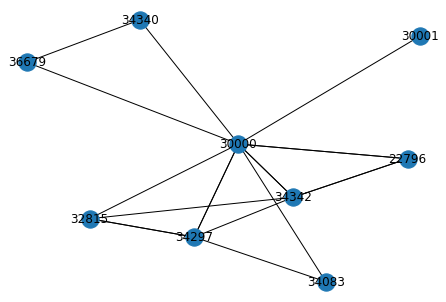

In [38]:
ego = nx.ego_graph(G_bidder, 30000) # ego network of the node
nx.draw(ego, with_labels=True)

In [100]:
#Lista anni
lista_unique_year=[]
for i in Pallottola['Date']:
    lista_unique_year.append(i.year)
insieme_year=set(lista_unique_year)
insieme_year

lista_unique_year_string=[]
for i in Pallottola['Date']:
    lista_unique_year_string.append(str(i.year)[-4:])
insieme_year_string=set(lista_unique_year_string)
insieme_year_string

{'1980',
 '1982',
 '1983',
 '1984',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021'}

In [40]:
from tqdm.notebook import tqdm
for anno in tqdm(insieme_year):
    locals()["SG_"+str(anno)]=nx.Graph([(u,v,d) for u,v,d in G_bidder.edges(data=True) if pd.to_datetime(d['date']).year==anno])

  0%|          | 0/40 [00:00<?, ?it/s]

In [41]:
from tqdm.notebook import tqdm
for anno in tqdm(insieme_year_string):
    locals()["SG_"+str(anno)+"string"]=nx.Graph([(u,v,d) for u,v,d in G_bidder.edges(data=True) if d['date']==anno])

  0%|          | 0/40 [00:00<?, ?it/s]

Nota bene: subgraph costruito non come multigraph 

In [43]:
nx.info(SG_2018)

'Name: \nType: Graph\nNumber of nodes: 3440\nNumber of edges: 13548\nAverage degree:   7.8767'

In [44]:
edges=[]
nodes=[]
avg_degree=[]
for anno in insieme_year:
    edges.append(locals()["SG_"+str(anno)].number_of_edges())
    nodes.append(locals()["SG_"+str(anno)].number_of_nodes())
    avg_degree.append(2*locals()["SG_"+str(anno)].number_of_edges()/(locals()["SG_"+str(anno)].number_of_nodes()+1))

<AxesSubplot:>

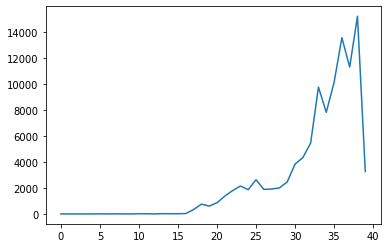

In [45]:
pd.Series(edges).plot()

Utile vedere ammontare denaro investito in gruppi >=2 e ammontare denaro quando hai solo un investitore - la domanda che ci siamo posti è un problema? Se un investitore partecipa da solo in 20 round significa che ti stai collegando ad uno con una certa expertise. Se investi con qualcuno che è sempre stato insieme a big player e poi ci investi da solo puoi scoprire se ha davvero la stoffa (è un follower o capisce bene gli investimenti da solo?). Invece se investi con qualcuno che ha sempre trovato deal da solo puoi giudicare bene quanto sia abile. 

Investitori che anticipano il trend e capiscono ottime opportunità o investitori hub che investono in cose medio buone che ne cambiano il destino perché si portano dietro altri investitori.

<b>Network direzionato</b> in cui punti tutti quelli che hanno investito in quell'azienda prima di te, per fare in modo di catturare quelli che hanno partecipato da soli ma che poi sono stati seguiti parecchio. Lo vedi con degree coming in elevato vs degree coming out basso. 

<AxesSubplot:>

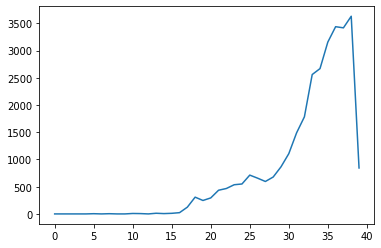

In [46]:
#Hai eliminato i lupi solitari
pd.Series(nodes).plot()

<AxesSubplot:>

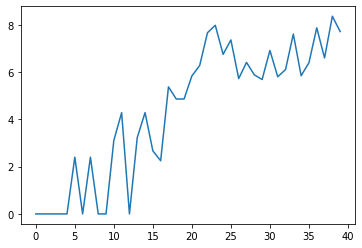

In [47]:
#Non hai contato lupi solitari, in teoria è inflazionato
pd.Series(avg_degree).plot()

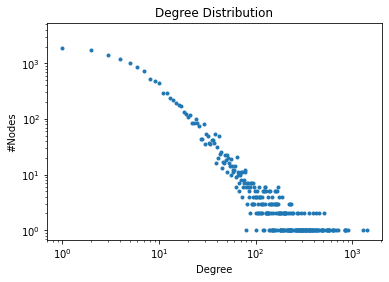

In [48]:
hist = nx.degree_histogram(G_bidder)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [49]:
density_anno=[]
for anno in lista_utilissima:
    density_anno.append(nx.density(locals()["SG_"+str(anno)]))
pd.Series(density_anno).plot()                                      

NameError: name 'lista_utilissima' is not defined

## Clustering Coefficient

Per costruzione il network avrà un alto clustering coefficient perché andiamo a costruirlo partendo dai round e quindi collegando tutti gli investitori che investono in un certo round (saranno quindi tutti collegati)

<AxesSubplot:>

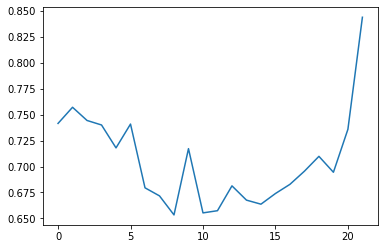

In [59]:
edges_clustering=[]
nodes_clustering=[]
avg_clustering=[]
for anno in insieme_year:
    if anno > 1999:
        avg_clustering.append(nx.average_clustering(locals()["SG_"+str(anno)]))
pd.Series(avg_clustering).plot()


## Degree centrality

Nei label degli edges potremmo mettere con quanti investitori sei collegato durante quel round, per capire quanto contribuisce al tuo degree

In [92]:
G_single = nx.Graph()
for u,v,data in G_bidder.edges(data=True):
    if data['m_raised']==np.nan:
        w=np.nan
    else:
        w = data['m_raised']*(1/((1/data['number'])-1))*(data['number']) if 'm_raised' in data else np.nan
    if G_single.has_edge(u,v):
        G_single[u][v]['weight'] += w
    else:
        G_single.add_edge(u, v, weight=w)

In [93]:
for u,v,data in G_single.edges(data=True):
    data['weight']=np.log(data['weight'])/50

In [53]:
nx.info(G_single)

'Name: \nType: Graph\nNumber of nodes: 14363\nNumber of edges: 85385\nAverage degree:  11.8896'

Necessario ricreare network con un solo collegamento pesato invece che tanti, con anche feature che ti dice sum(money_raised * number)

Nel passare a grafo singolo dobbiamo stare attenti al fatto che non è dinamico quindi se dobbiamo filtrare per anno o filtrare per round allora dobbiamo farlo sul multigrafo e poi trasformarlo in grafo (avrebbe anche senso filtrare per round per vedere a diversi stage di investimento come cambiano i rapporti tra investitori)

In [94]:
centrality_eigenvector_2=nx.eigenvector_centrality(G_single, max_iter=100, tol=1e-01, weight='weight')

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

(array([9.0000e+00, 6.3000e+01, 2.0400e+02, 1.8090e+03, 1.2073e+04,
        2.0347e+04, 2.7324e+04, 1.5174e+04, 1.5220e+03, 2.0000e+01]),
 array([0.13483362, 0.16624315, 0.19765268, 0.22906221, 0.26047174,
        0.29188127, 0.3232908 , 0.35470033, 0.38610986, 0.4175194 ,
        0.44892893]),
 <BarContainer object of 10 artists>)

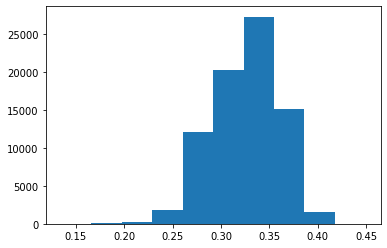

In [55]:
lista_utilissima=[]
for u,v,data in G_single.edges(data=True):
    lista_utilissima.append(data['weight'])
plt.hist((lista_utilissima))

In [82]:
centrality_general = nx.eigenvector_centrality(G_single)
degree_general = dict(nx.degree(G_single))
nodes['Bidder_eigenvectorc_general'] = np.nan
nodes['Bidder_degree_general'] = np.nan
for key,value in centrality_general.items():
    nodes.iloc[key, 8]=value
for key,value in degree_general.items():
    nodes.iloc[key, 9]=value

In [84]:
nodes[nodes['kind']=='Bidder'].sort_values('Bidder_eigenvectorc_general',ascending=False)[0:20]

,Node,Country,Coo,kind,id,coo,lat,long,Bidder_eigenvectorc_general,Bidder_degree_general
34462,OrbiMed,United States,"(40.7127281, -74.0060152)",Bidder,34462,"[40.7127281, -74.0060152]",40.712728,-74.006015,0.163197,584.0
33854,New Enterprise Associates,United States,"(37.4519671, -122.1779927)",Bidder,33854,"[37.4519671, -122.1779927]",37.451967,-122.177993,0.148077,522.0
39373,Venrock,United States,"(37.4443293, -122.1598465)",Bidder,39373,"[37.4443293, -122.1598465]",37.444329,-122.159847,0.120304,351.0
35531,RA Capital Management,United States,"(42.3602534, -71.0582912)",Bidder,35531,"[42.3602534, -71.0582912]",42.360253,-71.058291,0.117447,299.0
35143,Polaris Partners,United States,"(42.3602534, -71.0582912)",Bidder,35143,"[42.3602534, -71.0582912]",42.360253,-71.058291,0.117136,360.0
39442,Versant Ventures,United States,"(37.4519671, -122.1779927)",Bidder,39442,"[37.4519671, -122.1779927]",37.451967,-122.177993,0.114196,320.0
29264,GV,United States,"(37.3893889, -122.0832101)",Bidder,29264,"[37.3893889, -122.0832101]",37.389389,-122.083210,0.113386,350.0
33865,New Leaf Venture Partners,United States,"(40.7127281, -74.0060152)",Bidder,33865,"[40.7127281, -74.0060152]",40.712728,-74.006015,0.111475,266.0
34868,Perceptive Advisors,United States,"(40.7127281, -74.0060152)",Bidder,34868,"[40.7127281, -74.0060152]",40.712728,-74.006015,0.106407,269.0
23780,ARCH Venture Partners,United States,"(41.8755616, -87.6244212)",Bidder,23780,"[41.8755616, -87.6244212]",41.875562,-87.624421,0.103266,274.0


In [66]:
nodes[(nodes['kind']=='Bidder') & (nodes['Country']=='Italy')].sort_values('Bidder_centrality_general',ascending=False)[0:20]

,Node,Country,Coo,kind,id,coo,lat,long,Bidder_centrality_general,Bidder_degree_general
23231,Alice Ventures,Italy,"(45.4668, 9.1905)",Bidder,23231,"[45.4668, 9.1905]",45.466800,9.190500,0.003946,18.0
30298,Innogest Capital,Italy,"(45.4668, 9.1905)",Bidder,30298,"[45.4668, 9.1905]",45.466800,9.190500,0.003129,28.0
35212,Prana Ventures,Italy,"(45.4668, 9.1905)",Bidder,35212,"[45.4668, 9.1905]",45.466800,9.190500,0.002898,25.0
30199,Indaco Venture Partners,Italy,"(45.4668, 9.1905)",Bidder,30199,"[45.4668, 9.1905]",45.466800,9.190500,0.001651,19.0
37357,Sorin Group,Italy,"(45.4668, 9.1905)",Bidder,37357,"[45.4668, 9.1905]",45.466800,9.190500,0.001488,3.0
24668,Biofund,Italy,"(43.1672254, 11.467181161339118)",Bidder,24668,"[43.1672254, 11.467181161339118]",43.167225,11.467181,0.001452,2.0
24288,Banor SIM,Italy,"(45.4668, 9.1905)",Bidder,24288,"[45.4668, 9.1905]",45.466800,9.190500,0.001404,5.0
35617,Rancilio Cube,Italy,"(45.4668, 9.1905)",Bidder,35617,"[45.4668, 9.1905]",45.466800,9.190500,0.001349,4.0
35269,Principia SGR,Italy,"(45.4668, 9.1905)",Bidder,35269,"[45.4668, 9.1905]",45.466800,9.190500,0.001328,16.0
34642,Panakes Partners,Italy,"(45.4668, 9.1905)",Bidder,34642,"[45.4668, 9.1905]",45.466800,9.190500,0.001279,16.0


In [67]:
nodes.iloc[22576]

Node                             10XF
Country                           NaN
Coo                               NaN
kind                           Bidder
id                              22576
coo                               NaN
lat                               NaN
long                              NaN
Bidder_centrality_general    0.000077
Bidder_degree_general             4.0
Name: 22576, dtype: object

In [68]:
for key,value in centrality_general.items():
    nodes.at[nodes[nodes['id']==key].index[0],'Bidder_centrality_general']=value

Interessante <b>comparare degree centrality con eigenvector centrality</b>: nella eigenvector tu vedi l'effetto di amici potenti (con alto degree). Ci sono modi per calcolare centrality in network pesati non direzionati? Possiamo così pesare ciascun nodo con ammontare investimento. Quanto sei centrale rispetto al denaro e non alle persone o una combinazione delle due. <br>
<b> Betweenness centrality </b> : quanto sei ponte di collegamento tra mondi diversi

In [69]:
nodes['Bidder_centrality_general']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
40505    0.000224
40506    0.000035
40507         NaN
40508    0.001061
40509         NaN
Name: Bidder_centrality_general, Length: 40510, dtype: float64

In [70]:
for nodes.at[nodes[nodes['id']==2200].index[0],'Bidder_centrality_general']=np.nan

SyntaxError: invalid syntax (<ipython-input-70-37d85140ba52>, line 1)

## Memo per la prossima volta: plottare distribuzione del degree di ciascun anno

## Creazione di self-loops per sistemare i lupi solitari

Modifichiamo la funzione di creazione di link considerando una funzione di combinazione che prenda in considerazione anche la combinazione tra un elemento e sé stesso. In questo modo, se dovremo fare un filtro sui cosiddetti "lupi solitari" potremo farlo considerando i nodi con grado uguale a 1. Inoltre, in questo modo, non escludiamo i lupi solitari dai sottografi, ma inflazioniamo il grado generale del network (grado minimo=1)

In [150]:
# from tqdm.notebook import tqdm
links_f_string_self_loop = []
#ID in Pallottola indica il round e si ripete 
for i in tqdm(Pallottola['ID'].unique()):
    for couple in itertools.combinations_with_replacement(Pallottola[Pallottola['ID']==i].id_y.values,2):
        #if tot2[tot2['ID']==i]['conv'].values[0] != '-':
            links_f_string.append((couple + ({'m_raised': Pallottola[Pallottola['ID']==i]['USDraised_cpi'].values[0],
                             'date': pd.to_datetime(Pallottola[Pallottola['ID']==i]['Date'].values[0]).strftime("%d/%m/%Y"),
                             'round': Pallottola[Pallottola['ID']==i]['Funding type'].values[0],
                             'number': 1/(len(Pallottola[Pallottola['ID']==i])),
                             'type': 'invinv'},)))

### MEMO: Ricordati che devi modificare in links_f_string_self_loop qui sotto e ri-runnare sopra e anche links_f_string originario

In [95]:
G_bidder_string_self = nx.MultiGraph()
G_bidder_string_self.add_nodes_from(list(dic_bidder.items()))
G_bidder_string_self.add_edges_from(links_f_string_self_loop)

In [149]:
pd.Series(links_f_string_self).to_csv('~/links_f_string_self.csv')

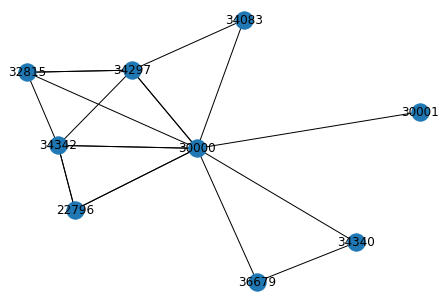

In [91]:
ego = nx.ego_graph(G_bidder_string_self, 30000) # ego network of the node
nx.draw(ego, with_labels=True)

Creiamo sottografi come multigraph

In [137]:
from tqdm.notebook import tqdm
for anno in tqdm(insieme_year_string):
    locals()["SG_self_"+str(anno)]=nx.MultiGraph([(u,v,d) for u,v,d in G_bidder_string_self.edges(data=True) if d['date'][-4:]==anno])

  0%|          | 0/40 [00:00<?, ?it/s]

In [124]:
lista_utilissima_numnodes=[]
for anno in tqdm(sorted(insieme_year_string)):
    lista_utilissima_numnodes.append(locals()["SG_self_"+str(anno)].number_of_nodes())

  0%|          | 0/40 [00:00<?, ?it/s]

In [132]:
len(lista_utilissima_numnodes)

40

<AxesSubplot:>

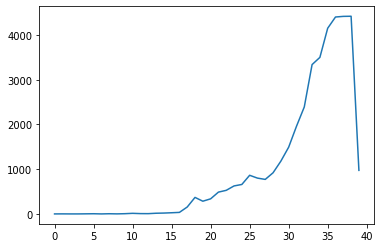

In [128]:
pd.Series(lista_utilissima_numnodes).plot()

In [138]:
edges_self=[]
nodes_self=[]
avg_degree_self=[]
for anno in sorted(insieme_year_string):
    edges_self.append(locals()["SG_self_"+str(anno)].number_of_edges())
    nodes_self.append(locals()["SG_self_"+str(anno)].number_of_nodes())
    avg_degree_self.append(2*locals()["SG_self_"+str(anno)].number_of_edges()/(locals()["SG_self_"+str(anno)].number_of_nodes()))

In [135]:
avg_degree_self

[2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 4.4,
 2.0,
 4.4,
 2.0,
 2.0,
 4.0,
 5.75,
 2.0,
 4.625,
 3.5,
 3.185185185185185,
 3.5428571428571427,
 6.335483870967742,
 6.059459459459459,
 6.231578947368421,
 7.094674556213017,
 7.610655737704918,
 8.795454545454545,
 8.84664536741214,
 7.644916540212443,
 8.083333333333334,
 6.704119850187266,
 6.958549222797927,
 6.343478260869565,
 6.1745762711864405,
 7.136729222520107,
 6.417773237997957,
 6.56234309623431,
 7.843572070722206,
 6.464265294453973,
 6.868643046517233,
 8.158181818181818,
 7.114182147711826,
 8.879329861897215,
 8.694045174537989]

<b>Confronto tra self-loops e non self-loops in avg degree plot</b>

<AxesSubplot:>

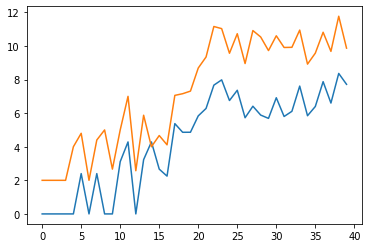

In [140]:
pd.Series(avg_degree).plot()
pd.Series(avg_degree_self).plot()

In [ ]:
G_single = nx.Graph()
for u,v,data in G_bidder.edges(data=True):
    if data['m_raised']==np.nan:
        w=np.nan
    else:
        w = data['m_raised']*(1/((1/data['number'])))*(1/data['number']) if 'm_raised' in data else np.nan
    if G_single.has_edge(u,v):
        G_single[u][v]['weight'] += w
    else:
        G_single.add_edge(u, v, weight=w)

## Clustering coefficient

Quanti sono i link presenti nel grafo sui link potenziali

In [71]:
lista_utilissima=[]
for i in insieme_year:
    if i>=2000 and i<2021:
        lista_utilissima.append(i)

In [72]:
lista_utilissima

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

Average degree rimane uguale ma il numero di nodi aumenta quindi density diminuisce

In [73]:
G_weighted = nx.Graph()
for u,v,data in G_bidder.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G_weighted[u][v]['weight'] += w
    else:
        G_weighted.add_edge(u, v, weight=w)

Scontare i legami nel grafo rispetto al tempo, con una sorta di weight decay. 
Ricordati che per come è costruito il grafo adesso se due investitori investono nella stessa company a stage diversi non hanno un collegamento, per cui il degree tiene conto di questo. Puoi comunque tentare di capire se ci sono investitori hub nel momento in cui studi il grafo bidder-target. Per questo motivo forse non ha senso cancellare i nodi che hanno degree pari a 0. Eppure se vogliamo renderlo da multigraph a weighted graph questi nodi vengono cancellati (la funzione che segue fa questo, passiamo da 17953 a 14363)

Creiamo un grafo dove i link sono più generici - basta avere company insieme. Con questo possiamo capire chi sono questi lupi solitari. Cosa interessante è vedere nel tempo quanti siano gli investitori solitari per ogni anno

Dobbiamo tornare nel grafo bipartito, vedere quando hanno fatto investimenti e contarli per l'anno. Creiamo un network con self-loop

In [74]:
lista_utilissima=[]
for anno in insieme_year:
    for i in list(nx.degree(locals()["SG_"+str(anno)])):
        if i[1]==0:
            lista_utilissima.append(i[1])
    print(len(lista_utilissima))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [75]:
nx.info(G_weighted)

'Name: \nType: Graph\nNumber of nodes: 14363\nNumber of edges: 85385\nAverage degree:  11.8896'

In [76]:
plt.plot(nx.degree(G_bidder),nx.clustering(G_bidder))
plt.yscale("log")
plt.xscale("log")
plt.show()

NetworkXNotImplemented: not implemented for multigraph type